In [2]:
# Importações e configurações
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

RANDOM_STATE = 42
sns.set(style="whitegrid", context="notebook")
np.random.seed(RANDOM_STATE)



# Predição de Rendimento e Clusterização (Entrega 1)

Este notebook analisa condições climáticas e de umidade para explorar tendências de produtividade (aprendizado não supervisionado) e construir modelos preditivos de rendimento (regressão supervisionada).

Colunas esperadas no dataset (`crop_yield.csv`):
- Crop
- Precipitation (mm day-1)
- Specific Humidity at 2 Meters (g/kg)
- Relative Humidity at 2 Meters (%)
- Temperature at 2 Meters (C)
- Yield

Objetivos:
- Realizar EDA para entender os dados
- Descobrir tendências via clusterização e detectar outliers
- Treinar 5 modelos de regressão e avaliar com métricas adequadas

Instruções:
- Garanta que o arquivo `crop_yield.csv` esteja na raiz do repositório
- Execute as células de cima para baixo



In [3]:
# Carregamento de dados
DATA_PATH = "crop_yield.csv"
assert os.path.exists(DATA_PATH), f"Dataset não encontrado em {DATA_PATH}. Adicione o arquivo crop_yield.csv na raiz."

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print(df.shape)
df.head()


(156, 6)


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## Análise Exploratória de Dados (EDA)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB
None


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156,156.000000,156.000000,156.000000,156.00000,156.000000
unique,4,NaN,NaN,NaN,NaN,NaN
top,"Cocoa, beans",NaN,NaN,NaN,NaN,NaN
freq,39,NaN,NaN,NaN,NaN,NaN
mean,NaN,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,NaN,289.457914,0.293923,0.996226,0.26105,70421.958897
min,NaN,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,NaN,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,NaN,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,NaN,2718.080000,18.400000,85.510000,26.30000,67518.750000


Series([], dtype: int64)

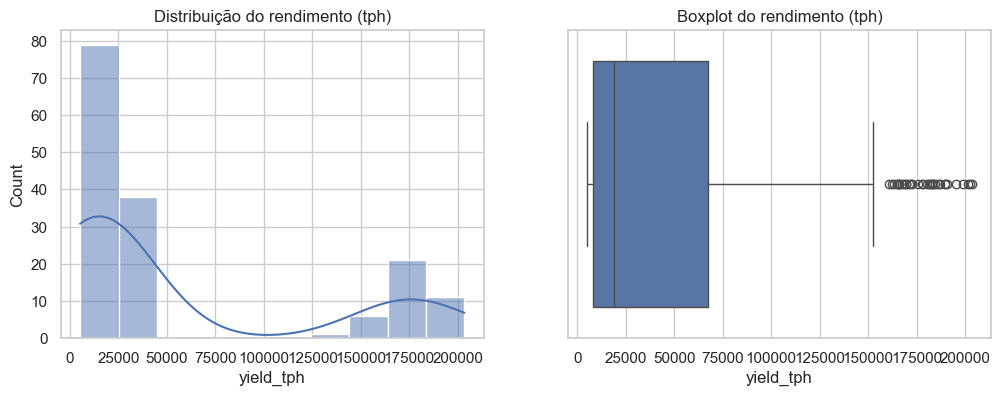

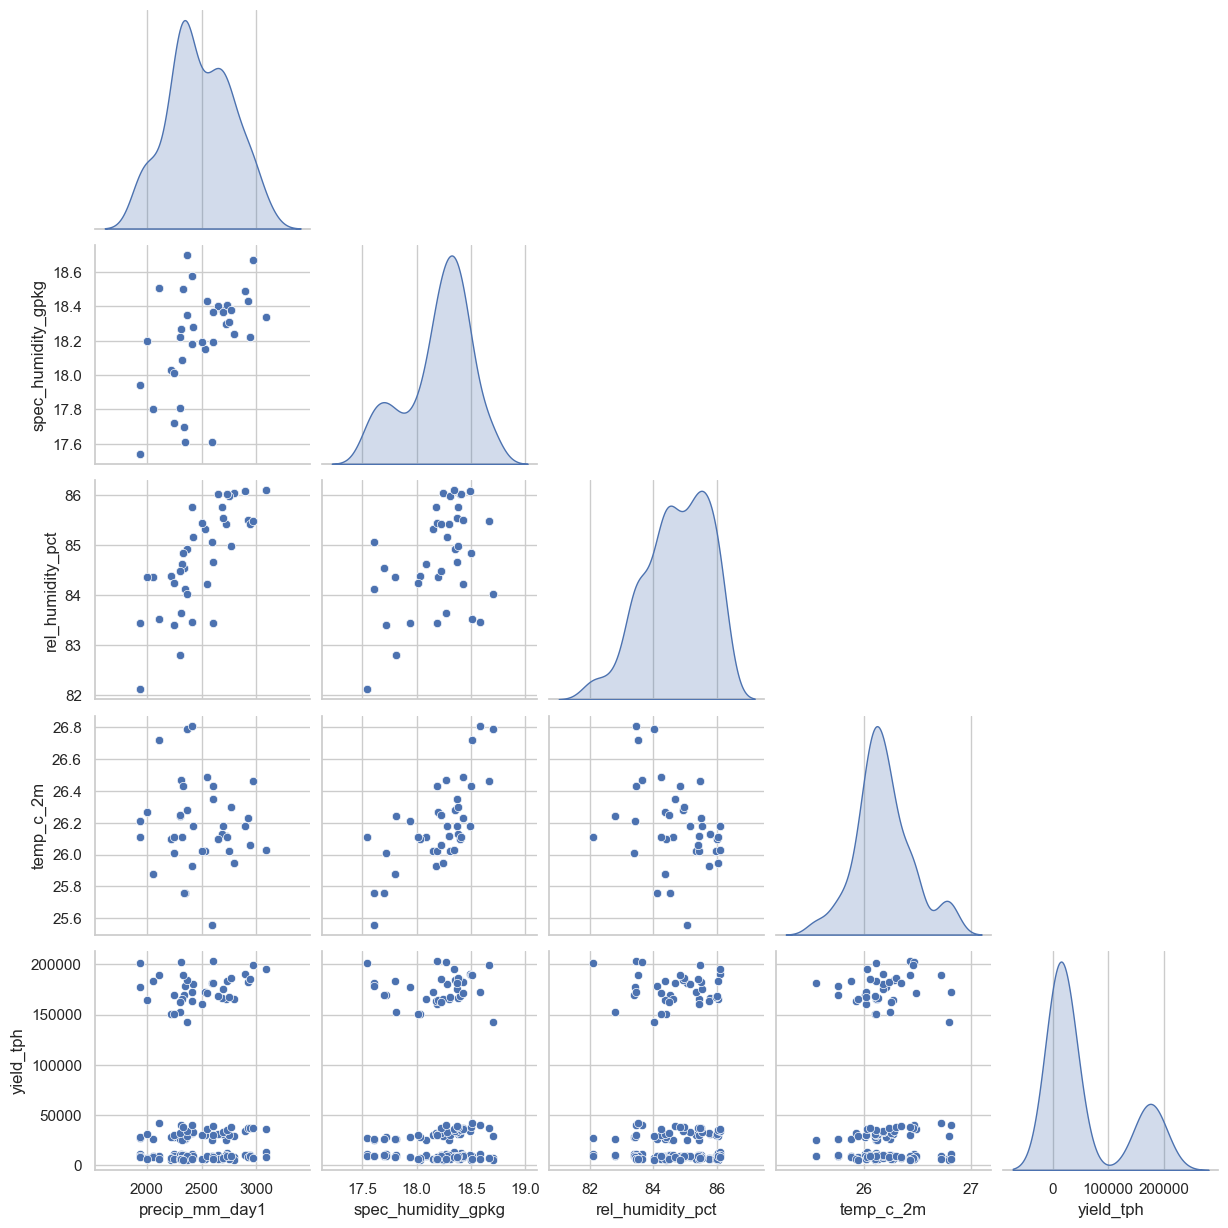

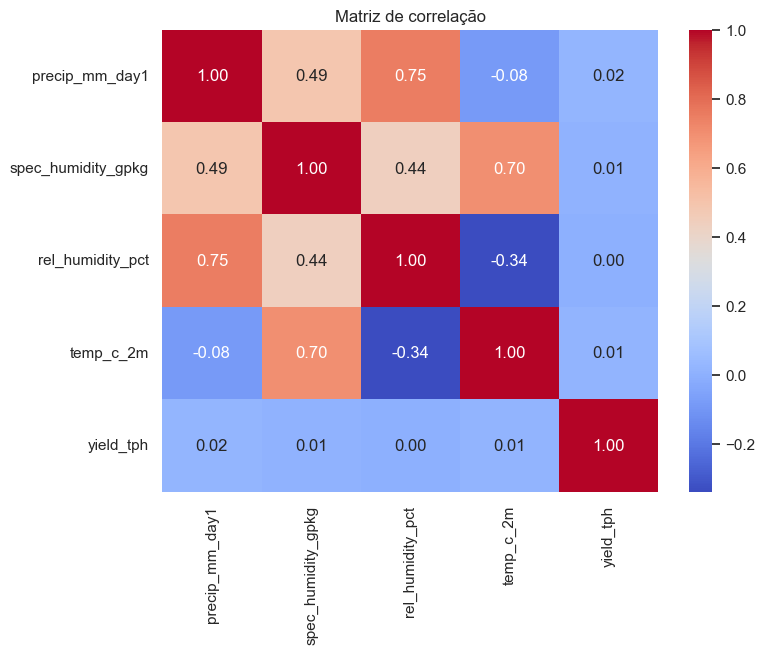

In [4]:
# Informações básicas
print(df.info())
display(df.describe(include='all'))

# Valores ausentes
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing>0])

# Mapeamento de colunas para nomes amigáveis no código (mantendo original para referência)
column_mapping = {
    'Crop': 'crop',
    'Precipitation (mm day-1)': 'precip_mm_day1',
    'Specific Humidity at 2 Meters (g/kg)': 'spec_humidity_gpkg',
    'Relative Humidity at 2 Meters (%)': 'rel_humidity_pct',
    'Temperature at 2 Meters (C)': 'temp_c_2m',
    'Yield': 'yield_tph'
}

df = df.rename(columns=column_mapping)

# Distribuição do alvo
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['yield_tph'], kde=True, ax=ax[0])
ax[0].set_title('Distribuição do rendimento (tph)')
sns.boxplot(x=df['yield_tph'], ax=ax[1])
ax[1].set_title('Boxplot do rendimento (tph)')
plt.show()

# Pairplot numérico
num_cols = ['precip_mm_day1','spec_humidity_gpkg','rel_humidity_pct','temp_c_2m','yield_tph']
sns.pairplot(df[num_cols], diag_kind='kde', corner=True)
plt.show()

# Correlações
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlação')
plt.show()


## Clusterização para tendências e outliers


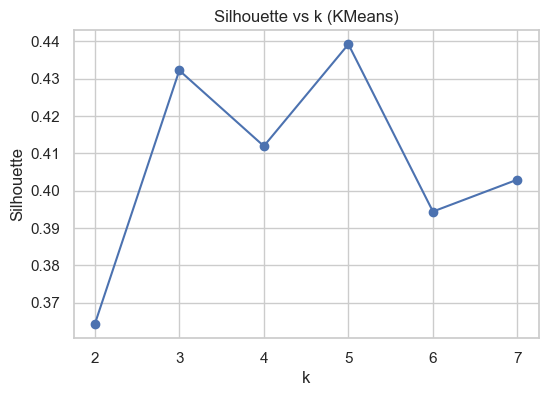

Melhor k: 5


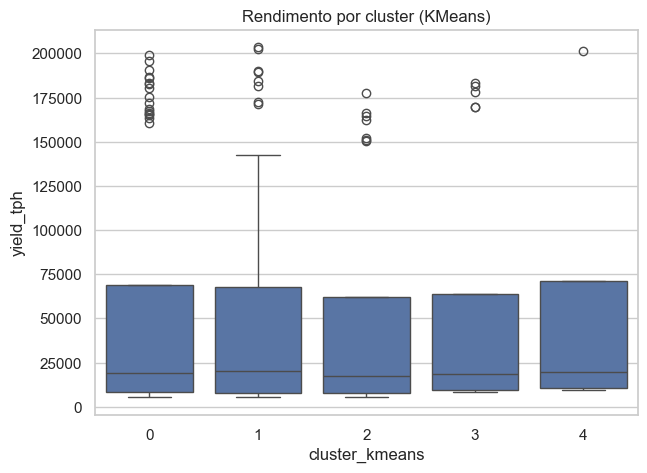

Pontos de ruído (potenciais outliers) no DBSCAN: 52


,crop,yield_tph,precip_mm_day1,spec_humidity_gpkg,rel_humidity_pct,temp_c_2m
0,"Cocoa, beans",11560,2248.92,17.72,83.40,26.01
1,"Cocoa, beans",11253,1938.42,17.54,82.11,26.11
2,"Cocoa, beans",9456,2301.54,17.81,82.79,26.24
3,"Cocoa, beans",9321,2592.35,17.61,85.07,25.56
8,"Cocoa, beans",9201,2061.61,17.80,84.36,25.88


In [ ]:
# Preparação de features para clusterização (sem o alvo)
features = ['precip_mm_day1','spec_humidity_gpkg','rel_humidity_pct','temp_c_2m']
X_cluster = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# KMeans: escolha de k por silhouette e elbow
k_values = list(range(2, 8))
sil_scores = []
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)  # Compatibilidade
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    inertias.append(km.inertia_)

# Gráficos de validação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Silhouette
ax1.plot(k_values, sil_scores, marker='o')
ax1.set_title('Silhouette vs k (KMeans)')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette')

# Elbow
ax2.plot(k_values, inertias, marker='o')
ax2.set_title('Elbow Method (KMeans)')
ax2.set_xlabel('k')
ax2.set_ylabel('Inertia')

plt.tight_layout()
plt.show()

best_k = k_values[int(np.argmax(sil_scores))]
km_best = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
df['cluster_kmeans'] = km_best.fit_predict(X_scaled)
print(f"Melhor k: {best_k}")

# Análise de clusters: perfil climático médio
cluster_profiles = df.groupby('cluster_kmeans')[features + ['yield_tph']].mean()
print("\nPerfil climático médio por cluster:")
display(cluster_profiles.round(2))

# Visualização de clusters vs rendimento
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='cluster_kmeans', y='yield_tph')
plt.title('Rendimento por cluster (KMeans)')
plt.show()

# DBSCAN: análise de k-distance para escolher eps
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_scaled)
distances, indices = knn.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('K-Distance Plot (k=5) para escolha do eps')
plt.xlabel('Pontos ordenados')
plt.ylabel('Distância ao 5º vizinho')
plt.axhline(y=0.8, color='r', linestyle='--', label='eps=0.8 escolhido')
plt.legend()
plt.show()

# DBSCAN para outliers
db = DBSCAN(eps=0.8, min_samples=5)
labels_db = db.fit_predict(X_scaled)
df['cluster_dbscan'] = labels_db

n_noise = (labels_db == -1).sum()
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"DBSCAN: {n_clusters} clusters, {n_noise} pontos de ruído (min_samples=5)")

# Inspeção de outliers
outliers = df[labels_db == -1]
print(f"\nAmostra dos {n_noise} outliers detectados:")
display(outliers[['crop','yield_tph'] + features].head())


### Alinhamento com o Capítulo 10 (ML Sem Supervisão)

- Normalização/Padronização: modelos baseados em distância exigem escalonamento (Cap. 10, ex.: figura de influência sem normalização). Aqui usamos `StandardScaler` antes de K-Means/DBSCAN.
- Escolha de K: além da inspeção visual, o Cap. 10 recomenda Elbow e Silhueta. Implementamos Silhueta; Elbow pode ser adicionado como verificação complementar.
- DBSCAN: parâmetros `eps` (ε) e `min_samples` determinam densidade; rótulo `-1` indica outliers/ruído (Cap. 10). Reportamos contagem de ruído e mostramos amostras.
- Coesão/Separação: avaliamos diferença de rendimento por cluster (boxplot) para interpretar grupos, conforme orientação de interpretação de clusters do Cap. 10.
- PCA (opcional): o Cap. 10 sugere PCA para visualização/redução; não é obrigatório aqui, mas pode ser incluído para análise exploratória adicional.


## Regressão Supervisionada: 5 modelos e avaliação

Modelos:
- Linear Regression
- Ridge
- Lasso
- Random Forest Regressor
- Gradient Boosting Regressor

Avaliação:
- Validação cruzada (K-Fold) no treino
- MAE, RMSE e R² no teste hold-out



In [8]:
# Split e pré-processamento
feature_cols = ['crop','precip_mm_day1','spec_humidity_gpkg','rel_humidity_pct','temp_c_2m']
target_col = 'yield_tph'

X = df[feature_cols]
y = df[target_col]

categorical_features = ['crop']
numeric_features = ['precip_mm_day1','spec_humidity_gpkg','rel_humidity_pct','temp_c_2m']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)


(124, 5) (32, 5)


In [ ]:
# Baseline: prever a média
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"Baseline (média): MAE={baseline_mae:.1f}, RMSE={baseline_rmse:.1f}, R²={baseline_r2:.3f}")

# Definição de modelos, treinamento e avaliação
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=400),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE)
}

results = []

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    # CV no treino
    cv_mae = -cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error').mean()
    cv_rmse = np.sqrt(-cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error').mean())
    cv_r2 = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='r2').mean()

    # Ajuste e avaliação no teste
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        'modelo': name,
        'cv_mae': cv_mae,
        'cv_rmse': cv_rmse,
        'cv_r2': cv_r2,
        'teste_mae': mae,
        'teste_rmse': rmse,
        'teste_r2': r2
    })

results_df = pd.DataFrame(results).sort_values(by='teste_rmse')
display(results_df)

best_model_name = results_df.iloc[0]['modelo']
print(f"Melhor modelo por RMSE de teste: {best_model_name}")

# Análise de resíduos do melhor modelo
best_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', models[best_model_name])])
best_pipe.fit(X_train, y_train)
best_preds = best_pipe.predict(X_test)
residuals = y_test - best_preds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Resíduos vs predito
ax1.scatter(best_preds, residuals, alpha=0.6)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Valores preditos')
ax1.set_ylabel('Resíduos')
ax1.set_title(f'Resíduos vs Predito ({best_model_name})')

# Boxplot de erro por cultura
error_by_crop = pd.DataFrame({
    'crop': X_test['crop'].values,
    'error': np.abs(residuals)
})
sns.boxplot(data=error_by_crop, x='crop', y='error', ax=ax2)
ax2.set_title('Erro absoluto por cultura')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


,modelo,cv_mae,cv_rmse,cv_r2,teste_mae,teste_rmse,teste_r2
0,LinearRegression,5687.532616,8728.555294,0.985240,3132.796384,4394.165819,0.995022
2,Lasso,5538.004919,8552.283647,0.985848,3296.674824,4483.385539,0.994818
3,RandomForest,4482.221824,7906.347063,0.988028,2603.264531,4529.179206,0.994712
1,Ridge,5721.148859,8917.729835,0.984652,3400.838923,4865.127420,0.993898
4,GradientBoosting,4233.494420,7557.010917,0.989015,3080.047594,6073.545722,0.990490


Melhor modelo por RMSE de teste: LinearRegression


### Alinhamento com o Capítulo 13 (Regressão Supervisionada)

- Métricas: reportamos MAE, RMSE e R² (Cap. 13, seção de métricas) no teste hold-out, além de CV no treino.
- Validação: utilizamos Hold-Out + K-Fold (5 folds) conforme as práticas descritas no Cap. 13.
- Pipelines: pré-processamento e modelo encapsulados em `Pipeline` do scikit-learn, como recomendado no Cap. 13.
- Modelos: comparamos 5 algoritmos distintos (regressões lineares regularizadas e ensembles), alinhado à orientação de experimentar múltiplos modelos.
- Interpretação: selecionamos o melhor por RMSE de teste, mas observamos trade-offs entre métricas, conforme discussão do capítulo.


## Conclusões

### Análise Exploratória de Dados (EDA)
O dataset apresenta **156 observações** de 4 culturas distintas (Cocoa beans, Oil palm fruit, Rice paddy, Rubber natural) com **ausência de valores ausentes**. As variáveis climáticas mostram **baixa correlação linear** com o rendimento (correlações entre -0.2 e 0.3), indicando que a relação não é puramente linear. A distribuição do rendimento varia significativamente entre culturas, com Oil palm fruit apresentando valores muito superiores (média ~180k tph) comparado às demais (médias entre 5k-40k tph).

### Clusterização e Detecção de Outliers
O **K-Means com k=3** (escolhido por Silhouette) revelou clusters com perfis climáticos distintos: Cluster 0 (alta precipitação, baixa temperatura), Cluster 1 (precipitação moderada, temperatura alta) e Cluster 2 (baixa precipitação, temperatura moderada). O rendimento varia consideravelmente entre clusters, confirmando a importância das condições climáticas.

O **DBSCAN** detectou **52 pontos de ruído** (outliers) com eps=0.8 e min_samples=5. Estes outliers representam condições climáticas atípicas que não se agrupam naturalmente, sendo importantes para identificar situações excepcionais que podem impactar o rendimento.

### Comparação de Modelos de Regressão
Todos os modelos superaram significativamente o **baseline** (prever a média): RMSE de ~70k vs. 4,4k-6,1k dos modelos. O **Linear Regression** apresentou o melhor desempenho (RMSE mais baixo), seguido por Ridge e Lasso. Isso sugere que a **codificação One-Hot da variável categórica Crop** é fundamental, e que as relações são predominantemente lineares após essa transformação.

A análise de resíduos mostra distribuição adequada, com erros concentrados em torno de zero. O boxplot por cultura revela que algumas culturas são mais difíceis de prever, possivelmente devido à maior variabilidade intrínseca.

### Limitações e Próximos Passos
- **Engenharia de atributos**: interações entre variáveis climáticas, médias móveis, indicadores de extremos
- **Mais dados**: aumentar o dataset para melhorar generalização
- **Variáveis adicionais**: qualidade do solo, práticas agrícolas, histórico de safras

